# NLP Application in Classifying Job Ads
_Aron Pap, Maximilian Müller, Keyvan Amini_

## Dataset and Objective

For text classification we used the Employment Scam Aegean Dataset (EMSCAD) which is a publicly available dataset containing 17,880 real-life job ads. The dataset contains 17,014 legitimate and 866 fraudulent job ads published between 2012 to 2014 (dataset available from here: http://emscad.samos.aegean.gr/)

Our main goal was to develop an NLP model which is capable of classifying job advertisements as legitimate or fraudulent, only using text features.

A paper has been published analyzing exactly this dataset and another goal was to see how our NLP models compare to the results of that paper (paper available online here: https://www.mdpi.com/1999-5903/9/1/6/htm )

We used following variables in string format for classifying whether the job ad is fraudulent or not:
* Company profile
* Description
* Requirements
* Benefits

## Pre-Processing

To ensure our algorithms can perform better (and also because our text variables were actually HTML fragments) we performed various steps in pre-processing the dataset, such as: removed stopwords, numbers and special characters, removed HTML tags and URLs, lowercasing. Some additional powerful methods such as stemming and lemmatization are automatically performed by the models we have used later. The code we used in the pre-processing is included in the other notebook (https://github.com/k-amini/NLP_RNN/blob/master/notebooks/NLP_data_preprocessing.ipynb).

When exploring the dataset we observed that there are duplicate rows, which would distort the cross-validation. In a second approach we therefore decided to remove the the observations where the job descriptions were identical. Moreover, since the classes in the original dataset were highly imbalanced we perfomed sampling inversely proportional to the class sizes, so that we ended up with a more balanced dataset, which we trained our models on. In summary, we ran our models for three different input datasets and compared the results, namely for:

* **Full Cleaned Dataset** (original dataset, 17880 observations)
* **Study/Paper Dataset** (balanced dataset from the paper referenced above, 900 observations)
* **Deduplicated, Balanced Cleaned Dataset** (the dataset we created, 2000 observations)

Here are the composition of the valid versus fraudulent observations in the different datasets:

**Full sample:**
* 659 fraudulent
* 14436 valid

**Study/Paper sample:**
* 450 fraudulent
* 450 valid

**Balanced train sample:**
* 586 fraudulent
* 1414 valid

## Models

### BiLSTM

Our first model was a BiLSTM model which applies a bidirectional multi-layer long short-term memory (LSTM) RNN to an input sequence. We chose this model since it seems to be really powerful for natural language processing application and quite straightforward to handle via Pytorch. <br>

The first step was building a vocabulary for our training text sets, we used the __glove.6B.100d__ pretrained word embeddings as a starting point for this (we tried other pretrained word embeddings as well, but this performed the best). This provides a 100-dimensional vector representation for each of our words, which is the initialization for the embedding layer of our BiLSTM model. The model will further optimize these word embeddings during the learning process. <br>

After the embedding layer our different BiLSTM model configurations had 2/3/4 hidden layers, with 16/32/64 nodes in each layer. The word embedding dimension was 100 and we outputted a single value across all model specifications. We used the __Sigmoid__ activation function in all models. The size of the vocabulary varied between 800-3200 depending on which text variable (company profile, description, benefits, requirements) we used. <br>


For the optimization of this model we used mini-batches of size 64 and the ADAM optimizer. Also, we used a dropout rate of 15-25% during training, but we did not use dropout during prediction. As a loss function, we choose the __binary cross-entropy__ criterion, but we also measured accuracy during training/validation. We trained every model configuration for 20 epoch and chose the model in the end, which had the lowest binary cross-entropy loss on the validation set.<br>

We also evaluated our best BiLSTM model (for each text variable) on independent test sets. We checked the __confusion matrix and the ROC-AUC curve__ for our own, balanced test set, the full, imbalanced dataset and also on the balanced dataset from the study/paper.

Notebook for this model available here: https://github.com/k-amini/NLP_RNN/blob/master/notebooks/NLP_BiLSTM.ipynb

### BERT

After being published last year, BERT, a NLP model with several hundreds of millions of parameters, was found to be incredibly successful in the world of NLP applications. It outperformed state-of-the-art models in many tasks and is especially known to have **increased context awareness**. This is why we decided to use it for our goal, namely the detection of false job ads. BERT's key technical innovation is the application of bidirectional training of Transformer, an attention model, to NLP. Instead of working through sequences from left to right or right to left, BERT in a way looks at the whole sentence, i.e. more in a bidirectional way. The authors of BERT explain that a bidirectionally trained model, even though it converges slower, is capable of detecting deeper sense of language context and flow. They therefore developed a new training technique called MLM which allowed for this bidirectional training in NLP applications. BERT also relies on **WordPiece tokenization**, which means that each word can be broken down into sub-words, which can be beneficial when dealing with out of vocabulary words. This is especially interesting for the job-ad task, as some words might be technical literature. For our task, we will fine-tune BERT by adding a layer for text classification and train on it. This way we can take advantage of the pre-trained BERT model, which should extract relevant features from the text, which we in the end can classify with the last layer. In this fine-tuning application it is recommended to mostly stick to the hyperparameters that were suggested by the authors. We followed these suggestions and just changed the number of training epochs sligthly. BERT was mostly used for single- or 2-sentence applications and also question-answer tasks, which is why it is restricted to 512 input tokens. We therefore only use the first 512 words of each job-description and tell BERT to treat it as a single sentence.

Similar to the BiLSTM we evaluated the perfomance of the model with confusion matrix and the ROC-AUC curve.

Notebooks for this model are available here: <br>
https://github.com/k-amini/NLP_RNN/blob/master/notebooks/Bert_Train.ipynb <br>
https://github.com/k-amini/NLP_RNN/blob/master/notebooks/Bert_Evaluate.ipynb

## Model Parameter Tuning

### 1. BiLSTM

In [2]:
from IPython.core.display import HTML 
from IPython.display import Image
from IPython.display import display
x= Image(url= "https://raw.githubusercontent.com/k-amini/NLP_RNN/master/Outputs/epoch_losses/benefits_loss_model3.png")
y= Image(url= "https://raw.githubusercontent.com/k-amini/NLP_RNN/master/Outputs/epoch_losses/description_loss_model3.png")
u= Image(url= "https://raw.githubusercontent.com/k-amini/NLP_RNN/master/Outputs/epoch_losses/requirements_loss_model3.png")
#x = Image(filename='benefits_loss_model3.png') 
#y = Image(filename='description_loss_model3.png') 
#u = Image(filename='requirements_loss_model3.png') 
display(x, y, u)

The three plots above show the training and validation losses for different text variables: __description, benefits, and requirements__. We can depict from the plots that validation loss is going up after more or less 15 epochs. In our implementation, the model with the lowest validation loss was saved automatically, so that we could avoid overfitting, even if we used too many epoch initially.

### 2. BERT

In [3]:
Image(url= "https://raw.githubusercontent.com/k-amini/NLP_RNN/master/Outputs/epoch_losses/bert_training_loss.png" )

The authors of Bert recommend 1-4 training epochs. However, we found that best results on an independent test set were obtained with 5 training epochs and thus went for that value. The other parameters like learning rate and optimizer were not changed.

## Word Embedding Exploration

We also visualized the high-dimensional (100-dim) vector representation of our vocabulary in the BiLSTM model, using the T-SNE (t-distributed Stochastic Neighbor Embedding) algorithm to be able to represent the word embeddings in 2 dimensions. We initialized the T-SNE algorithm with PCA and run it for 2500 iterations using a perplexity parameter of 40. The resulting figures for the different text variables are shown below.

One example of the word embedding we get is illustrated below:

### Job Description

In [3]:
Image(url= "https://raw.githubusercontent.com/k-amini/NLP_RNN/master/Outputs/t_sne_description.png")

The word embeddings for the other three variables can be found on github: https://github.com/k-amini/NLP_RNN

# Result Summary of Models

In [7]:
import tabletext

data = [["Model (Data)","Description Acc.","Company Profile Acc.","Benefits Acc.","Requirements Acc."],
        ["BiLSTM (Study Data)",0.88,"-","-","-"],
        ["BiLSTM (Dedupl. & Balanced Data)",0.76,0.74,0.74,0.76],
        ["BERT (Study Data)",0.93,"-","-","-"],
        ["BERT (Dedupl. & Balanced Data)",0.88,0.83,0.67,0.69]
        ]

print (tabletext.to_text(data))

┌──────────────────────────────────┬──────────────────┬──────────────────────┬───────────────┬───────────────────┐
│ Model (Data)                     │ Description Acc. │ Company Profile Acc. │ Benefits Acc. │ Requirements Acc. │
├──────────────────────────────────┼──────────────────┼──────────────────────┼───────────────┼───────────────────┤
│ BiLSTM (Study Data)              │             0.88 │ -                    │ -             │ -                 │
├──────────────────────────────────┼──────────────────┼──────────────────────┼───────────────┼───────────────────┤
│ BiLSTM (Dedupl. & Balanced Data) │             0.76 │                 0.74 │          0.74 │              0.76 │
├──────────────────────────────────┼──────────────────┼──────────────────────┼───────────────┼───────────────────┤
│ BERT (Study Data)                │             0.93 │ -                    │ -             │ -                 │
├──────────────────────────────────┼──────────────────┼──────────────────────┼──

## Results Dedupl. & Balanced Data

When trained with the deduplicated and balanced dataset we can observe that overall BERT reaches higher accuracy for the individual predictions "Description" and "Company Profile", where the other two variables perform worse. Even though we were surprised to see a correct prediction in 93% of the cases looking at the Description for BERT what surprised us even more is that actually also the company profile correctly classifies the fraudulent cases in 83% of the cases. A possible explanation for this is that the fraudulent cases had missing descriptions, which in itself is an indicator for a non-existent firm.

## Comparison with Study Results

The authors of the previously referenced paper used hand-crafted features and a special subset of data (that they found representative) for the training and evaluation of the dataset. They performed leave-one-out cross-validation and obtained a final accuracy of 90%. Due to computational restrictions we could not perform leave-one-out cross-validation. We therefore performed a random 90-10 train-test split on the data the authors used, trained our models on the train set and evaluated them on the independent test set. This way we have less data for training than the authors of the paper, but we expect a realistic estimation of the accuracy of the obtained model that is comparable to the leave-one-out accuracy. With the BiLSTM we got 88% and with BERT 93% (see also table above). We can therefore proudly claim to have beaten the method of the paper, with using even less training data than them and without using handcrafted features.

# Ensemble

After we have separately retrieved classifications from each of our predictors including the corresponding prediction probabilities we decided to create a ensemble to holistically predict the label taking into consideration all of the predictions from all variables (company profile, description, requirements and benefits). So we basically predict the target label now from 4 variables which are represented as probabilities. The code herefore is presented in the following and a discussion of the results can be found at the end of the notebook:

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, confusion_matrix

In [6]:
def confusion_matrix_builder(dataframe,true_colname,pred_colname):

    # Initialize confusion matrix
    conf_matrix = np.zeros((2,2))

    # Loop over matrix entries and calculate the values
    for i in range(0,len(dataframe)):
        if dataframe[true_colname].iloc[i] == 1 and dataframe[pred_colname].iloc[i] == 1:
            conf_matrix[1,1] += 1
        elif dataframe[true_colname].iloc[i] == 0 and dataframe[pred_colname].iloc[i] == 0:
            conf_matrix[0,0] += 1
        elif dataframe[true_colname].iloc[i] == 1 and dataframe[pred_colname].iloc[i] == 0:
            conf_matrix[1,0] += 1
        else:
            conf_matrix[0,1] += 1

    return conf_matrix

In [7]:
import seaborn as sns
def plot_confusion_matrix(cm, class_labels):
    """Pretty prints a confusion matrix as a figure

    Args:
        cm:  A confusion matrix for example
        [[245, 5 ], 
         [ 34, 245]]
         
        class_labels: The list of class labels to be plotted on x-y axis

    Rerturns:
        Just plots the confusion matrix.
    """
    
    df_cm = pd.DataFrame(cm, index = [i for i in class_labels],
                  columns = [i for i in class_labels])
    sns.set(font_scale=1)
    sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
    plt.rcParams["figure.figsize"] = (5,5)
    plt.xlabel("Predicted label")
    plt.ylabel("Real label")
    plt.show()

In [8]:
def get_auc(y, y_pred_probabilities, class_labels, column =1, plot = True):
    """Plots ROC AUC
    """
    fpr, tpr, _ = roc_curve(y, y_pred_probabilities,drop_intermediate = False)
    #roc_auc = roc_auc_score(y_true=y, y_score=y_pred_probabilities[:,1])
    roc_auc = roc_auc_score(y_true=y, y_score=y_pred_probabilities)
    print ("AUC: ", roc_auc)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for the BiLSTM model on the test set')
    plt.legend(loc="lower right")
    plt.show()

# BiLSTM Results in Ensemble

### Data Loading & Aggregating Predictions into Ensemble

In [9]:
# Bi-directional
benefits_df = pd.read_csv('test_preds_bilstm_benefits.csv')
descr_df = pd.read_csv('test_preds_bilstm_description.csv')
comp_prof_df = pd.read_csv('test_preds_bilstm_company_profile.csv')
requirements_df = pd.read_csv('test_preds_bilstm_requirements.csv')

In [10]:
ensemble = benefits_df.copy()
ensemble = ensemble["fraudulent"]
ensemble = pd.DataFrame(ensemble)
ensemble[["pred_benef","pred_rew_proba_benef"]] = benefits_df[["pred_rew","pred_rew_proba"]]
ensemble[["pred_descr","pred_rew_proba_descr"]] = descr_df[["pred_rew","pred_rew_proba"]]
ensemble[["pred_comp_prof","pred_rew_proba_prof"]] = comp_prof_df[["pred_rew","pred_rew_proba"]]
ensemble[["pred_comp_requ","pred_rew_proba_requ"]] = requirements_df[["pred_rew","pred_rew_proba"]]

In [11]:
ensemble_prob = ensemble[['fraudulent', 'pred_rew_proba_benef','pred_rew_proba_descr', 'pred_rew_proba_prof', 'pred_rew_proba_requ']]

In [12]:
# Prepare variables for model
y = ensemble_prob['fraudulent']
X = ensemble_prob.drop(['fraudulent'],axis=1)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Random Forest

In [14]:
np.random.seed(3123)
feature_names = X_train.columns
forest = RandomForestClassifier(n_estimators=20)  #Setting n_estimator to prevent overfitting
forest_fitted = forest.fit(X_train, y_train) 
scores = cross_val_score(forest, X_train, y_train, cv=5)
y_pred_forest = forest.predict(X_test)

In [15]:
# Also predicting probabilities to be used for the AUC
y_pred_proba = forest.predict_proba(X_test)

## Assessing Accuracy and Feature Importance

In [16]:
# Step 5: Assess expected accuracy
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Step 6: Assess variable importance
importances = forest.fit(X,y).feature_importances_
important_features = pd.Series(data=importances/importances.max() ,index=feature_names)
important_features.sort_values(ascending=False)

Accuracy: 0.86 (+/- 0.06)


pred_rew_proba_prof     1.000000
pred_rew_proba_descr    0.596620
pred_rew_proba_requ     0.413856
pred_rew_proba_benef    0.336423
dtype: float64

In [19]:
test_y = pd.DataFrame(y_test.copy())
test_y["prediction"] = y_pred_forest

conf_matrix = confusion_matrix_builder(dataframe=test_y,
                                       true_colname='fraudulent',
                                       pred_colname='prediction')
# Print results
print(conf_matrix)

[[77.  6.]
 [10. 32.]]


Accuracy Score : 0.872
Precision Score : 0.8421052631578947
Recall Score : 0.7619047619047619
F1 Score : 0.8


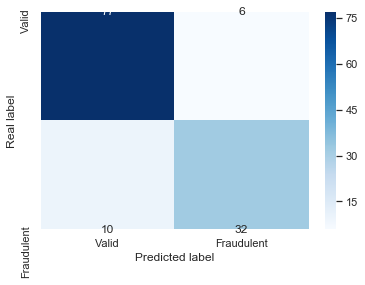

In [20]:
print('Accuracy Score : ' + str(accuracy_score(test_y['fraudulent'],test_y['prediction'])))
print('Precision Score : ' + str(precision_score(test_y['fraudulent'],test_y['prediction'])))
print('Recall Score : ' + str(recall_score(test_y['fraudulent'],test_y['prediction'])))
print('F1 Score : ' + str(f1_score(test_y['fraudulent'],test_y['prediction'])))

plot_confusion_matrix(conf_matrix, class_labels=['Valid','Fraudulent'])

AUC:  0.8924268502581756


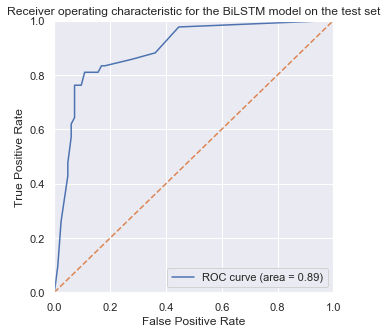

In [21]:
get_auc(y=y_test, y_pred_probabilities=y_pred_proba[:,1],
        class_labels=['Valid','Fraudulent'],
        column =1, plot = True)

# BERT Results in Ensemble

### Data Loading & Aggregating Predictions into Ensemble

In [22]:
# Bert
ensemble_bert = pd.read_csv('Bert_balanced_nodupl_5epochs_test_preds.csv')

In [23]:
ensemble_prob_bert = ensemble_bert[['fraudulent', 'pred_proba_benefits','pred_proba_description', 'pred_proba_company_profile', 'pred_proba_requirements']]

In [24]:
# Prepare variables for model
y = ensemble_prob_bert['fraudulent']
X = ensemble_prob_bert.drop(['fraudulent'],axis=1)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [26]:
feature_names = X_train.columns
forest = RandomForestClassifier(n_estimators=20)  #Setting n_estimator to prevent overfitting
forest_fitted = forest.fit(X_train, y_train) 
scores = cross_val_score(forest, X_train, y_train, cv=5)
y_pred_forest = forest.predict(X_test)

In [27]:
# Also predicting probabilities to be used for the AUC
y_pred_proba = forest.predict_proba(X_test)

## Assessing Accuracy and Feature Importance

In [28]:
# Step 5: Assess expected accuracy
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Step 6: Assess variable importance
importances = forest.fit(X,y).feature_importances_
important_features = pd.Series(data=importances/importances.max() ,index=feature_names)
important_features.sort_values(ascending=False)

Accuracy: 0.87 (+/- 0.05)


pred_proba_description        1.000000
pred_proba_requirements       0.593532
pred_proba_company_profile    0.241190
pred_proba_benefits           0.183746
dtype: float64

In [29]:
test_y = pd.DataFrame(y_test.copy())
test_y["prediction"] = y_pred_forest

conf_matrix = confusion_matrix_builder(dataframe=test_y,
                                       true_colname='fraudulent',
                                       pred_colname='prediction')
# Print results
print(conf_matrix)

[[75.  8.]
 [ 9. 33.]]


Accuracy Score : 0.864
Precision Score : 0.8048780487804879
Recall Score : 0.7857142857142857
F1 Score : 0.7951807228915663


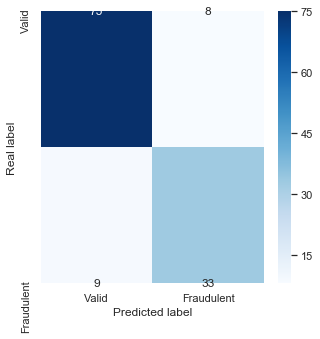

In [30]:
print('Accuracy Score : ' + str(accuracy_score(test_y['fraudulent'],test_y['prediction'])))
print('Precision Score : ' + str(precision_score(test_y['fraudulent'],test_y['prediction'])))
print('Recall Score : ' + str(recall_score(test_y['fraudulent'],test_y['prediction'])))
print('F1 Score : ' + str(f1_score(test_y['fraudulent'],test_y['prediction'])))

plot_confusion_matrix(conf_matrix, class_labels=['Valid','Fraudulent'])

AUC:  0.9290017211703958


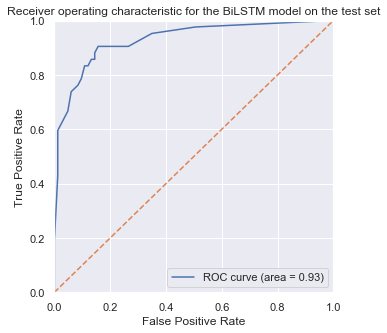

In [31]:
get_auc(y=y_test, y_pred_probabilities=y_pred_proba[:,1],
        class_labels=['Valid','Fraudulent'],
        column =1, plot = True)

# Results Ensemble

In [8]:
data = [["Model (Data)","Description Acc."],
        ["Ensemble BERT Predictions (Dedupl. & Balanced Data)",0.87],
        ["Ensebmle BiLSTM Predictions (Dedupl. & Balanced Data)",0.86],
        ]

print (tabletext.to_text(data))

┌───────────────────────────────────────────────────────┬──────────────────┐
│ Model (Data)                                          │ Description Acc. │
├───────────────────────────────────────────────────────┼──────────────────┤
│ Ensemble BERT Predictions (Dedupl. & Balanced Data)   │             0.87 │
├───────────────────────────────────────────────────────┼──────────────────┤
│ Ensebmle BiLSTM Predictions (Dedupl. & Balanced Data) │             0.86 │
└───────────────────────────────────────────────────────┴──────────────────┘


## Results Individual Models (for comparison)

In [9]:
data = [["Model (Data)","Description Acc.","Company Profile Acc.","Benefits Acc.","Requirements Acc."],
        ["BiLSTM (Study Data)",0.88,"-","-","-"],
        ["BiLSTM (Dedupl. & Balanced Data)",0.76,0.74,0.74,0.76],
        ["BERT (Study Data)",0.93,"-","-","-"],
        ["BERT (Dedupl. & Balanced Data)",0.88,0.83,0.67,0.69]
        ]

print (tabletext.to_text(data))

┌──────────────────────────────────┬──────────────────┬──────────────────────┬───────────────┬───────────────────┐
│ Model (Data)                     │ Description Acc. │ Company Profile Acc. │ Benefits Acc. │ Requirements Acc. │
├──────────────────────────────────┼──────────────────┼──────────────────────┼───────────────┼───────────────────┤
│ BiLSTM (Study Data)              │             0.88 │ -                    │ -             │ -                 │
├──────────────────────────────────┼──────────────────┼──────────────────────┼───────────────┼───────────────────┤
│ BiLSTM (Dedupl. & Balanced Data) │             0.76 │                 0.74 │          0.74 │              0.76 │
├──────────────────────────────────┼──────────────────┼──────────────────────┼───────────────┼───────────────────┤
│ BERT (Study Data)                │             0.93 │ -                    │ -             │ -                 │
├──────────────────────────────────┼──────────────────┼──────────────────────┼──

Since we trained separate NLP models for the 4 text variables, our idea was to combine their results to build a "superlearner". Therefore we trained an ensemble, which takes the probability predictions from the separate NLP models and uses a random forest algorithm to best combine them. However as we can see on the accuracy results, this extension does not bring the expected improvement in accuracy. Actually, compared to the BERT - description model, the accuracy even decreased. One potential reason for this is the small training sample, since we had to split the already "small" independent test set into a train and validation set to train the ensemble. Another reason for this result might be that the random forest randomly selects the features that it uses for each subspace partition, therefore sometimes it does not use the probability prediction from the 'Description' model which is way better for the BERT than the other text variables. This problem could be solved for example via using a simple decision tree, but that could raise different problems (instability etc). Another interesting result to note that the ensemble substantially improved the accuracy for the BiLSTM models (bringing ~10% point accuracy improvement compared to the separate, single models).